# Including COVID 19

# Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.argv = ['']

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from datetime import datetime 
import itertools
import argparse 
import re 
import os
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

# Environment

In [3]:
class Environment:
    
    def __init__(self,data,initial_investment,num_stocks):
        
        
        self.data=data
        self.num_samples,self.num_features=self.data.shape
        
        
        
        self.num_stocks=num_stocks
        #self.num_features=total_features-self.num_stocks
        
        self.initial_investment=initial_investment
        self.curr_step=None
        self.stock_owned=None
        self.stock_price=None
        self.stock_features=None
        self.cash_in_hand=None
        
        
        
        self.action_space=np.arange(3**self.num_stocks)
        
        self.action_list = list(map(list, itertools.product(np.arange(self.num_stocks), repeat=self.num_stocks)))
        
        self.state_dim=self.num_features+(self.num_stocks)+1
        self.reset()
        
    def reset(self):
        self.curr_step=0
        self.stock_features=self.data.loc[self.curr_step,['Price_BXPH','Price_LBFL','Price_RNTL','MACD_BXPH','RSI_BXPH','CCI_BXPH','ADX_BXPH','MACD_LBFL','RSI_LBFL','CCI_LBFL','ADX_LBFL','MACD_RNTL','RSI_RNTL','CCI_RNTL','ADX_RNTL','Vol_BXPH','Vol_RNTL','Vol_LBFL']]
        self.stock_price=self.data.loc[self.curr_step,['Price_BXPH','Price_LBFL','Price_RNTL']]
        self.stock_owned=np.zeros(self.num_stocks)
        self.cash_in_hand=self.initial_investment
        
        return self.get_state()
    
    def step(self,action):
        
        previous_value= self.get_value()
        
        self.stock_price=self.data.loc[self.curr_step,['Price_BXPH','Price_LBFL','Price_RNTL']]
        self.stock_features=self.data.loc[self.curr_step,['Price_BXPH','Price_LBFL','Price_RNTL','MACD_BXPH','RSI_BXPH','CCI_BXPH','ADX_BXPH','MACD_LBFL','RSI_LBFL','CCI_LBFL','ADX_LBFL','MACD_RNTL','RSI_RNTL','CCI_RNTL','ADX_RNTL','Vol_BXPH','Vol_RNTL','Vol_LBFL']]
        
        #perform action
        self.trade(action)
        
        self.curr_step+=1
        
        self.stock_price=self.data.loc[self.curr_step,['Price_BXPH','Price_LBFL','Price_RNTL']]
        self.stock_features=self.data.loc[self.curr_step,['Price_BXPH','Price_LBFL','Price_RNTL','MACD_BXPH','RSI_BXPH','CCI_BXPH','ADX_BXPH','MACD_LBFL','RSI_LBFL','CCI_LBFL','ADX_LBFL','MACD_RNTL','RSI_RNTL','CCI_RNTL','ADX_RNTL','Vol_BXPH','Vol_RNTL','Vol_LBFL']]
        
        curr_value=self.get_value()
        
        reward=curr_value-previous_value
        
        
        done= (self.curr_step==self.num_samples-1)
        
        info={'current value' : curr_value}
        
        return self.get_state(),reward,done,info
    
    
    def get_value(self):
        return self.stock_owned.dot(self.stock_price)+self.cash_in_hand
    
    def get_state(self):
        state=np.empty(self.state_dim)
        state[:self.num_features]=self.stock_features
        state[self.num_features:self.num_features+self.num_stocks]=self.stock_owned
        state[-1]=self.cash_in_hand
        
        return state
    
    def trade(self,action):
        # 0:sell
        # 1:hold
        # 2:buy
        action_vector=self.action_list[action]
        
        sell_index=[]
        buy_index=[]
        
        for i in range(len(action_vector)):
            if action_vector[i]==0:
                sell_index.append(i)
            elif action_vector[i]==2:
                buy_index.append(i)
                
                
        if sell_index:
            for i in sell_index:
                self.cash_in_hand=self.cash_in_hand+self.stock_owned[i]*self.stock_price[i]
                self.stock_owned[i]=0
                
        if buy_index:
            can_buy=True
            while can_buy:
                can_buy=False
                for i in buy_index:
                    if self.cash_in_hand>self.stock_price[i]:
                        self.cash_in_hand=self.cash_in_hand-self.stock_price[i]
                        self.stock_owned[i]+=1
                        
                        if self.cash_in_hand > self.stock_price[i]:
                            can_buy = True

# Model

In [4]:
class LinearModel:
    # Linear Regression
    def __init__(self,state_dim,action_dim):
        self.W = np.random.randn(state_dim,action_dim) / np.sqrt(state_dim)
        self.b = np.zeros(action_dim)

        # momentum terms 
        self.vW = 0
        self.vb = 0

        self.losses = []
        self.prediction = []
        self.actual_value = []

    def predict(self,X):
        assert(len(X.shape)==2)
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9): # Stochastic gradent descent
        assert(len(X.shape)==2)

        num_values=np.prod(Y.shape)

        Yhat= self.predict(X)
        gW= 2*X.T.dot(Yhat - Y)/num_values
        gb= 2*(Yhat-Y).sum(axis=0)/num_values

        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb 

        self.W +=  self.vW
        self.b +=  self.vb

        mse = np.mean((Yhat-Y)**2)
        self.losses.append(mse)

    def save_weights(self,filepath):
        np.savez(filepath, W=self.W, b=self.b)

    def load_weights(self,filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']

# Agent

In [5]:
class Agent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95 # discount factor
        self.epsilon = 1.0 # exploration
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)
        self.q_value=[]

    def act(self,state): # epsilon-greedy! return integer [1,27]
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size) # return random action with probability epsilon
        act_values = self.model.predict(state) 
        self.q_value.append(act_values)
        return np.argmax(act_values[0]) # return the best action based on the Q-values with probability 1-epsilon

    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis = 1) # Q-Learning

        target_full = self.model.predict(state) # Get the values based on the old parameters W,b
        target_full[0,action] = target # update the entry of the corresponding action

        self.model.sgd(state, target_full) # Stochastic gradient descent. Run one training step and update W, b

        if self.epsilon > self.epsilon_min: #decrease the probability of exploration
            self.epsilon *= self.epsilon_decay

    def load(self,name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
abc = pd.read_csv('/content/drive/MyDrive/stock project/data/stock_data.csv')
abc.tail()

,Date,Price_BXPH,Vol_BXPH,MACD_BXPH,RSI_BXPH,CCI_BXPH,ADX_BXPH,Price_LBFL,Vol_LBFL,MACD_LBFL,RSI_LBFL,CCI_LBFL,ADX_LBFL,Price_RNTL,Vol_RNTL,MACD_RNTL,RSI_RNTL,CCI_RNTL,ADX_RNTL
1924,2022-10-24,160.2,167840.0,-1.428224,39.985917,-76.732074,22.02,26.0,410.0,-0.190909,38.659313,NaN,29.55,1303.2,910.0,-0.503972,44.253417,0.000000,50.74
1925,2022-10-25,160.2,299410.0,-1.849396,39.985917,-74.937598,22.04,26.0,17390.0,-0.178547,38.659313,NaN,29.46,1303.2,950.0,-0.469588,44.253417,0.000000,51.10
1926,2022-10-26,158.0,354480.0,-2.333796,37.762082,-130.120408,22.05,26.0,5550.0,-0.166827,38.659313,NaN,29.36,1303.2,440.0,-0.437297,44.253417,0.000000,51.42
1927,2022-10-27,156.4,185860.0,-2.814352,36.185864,-112.518223,22.53,26.0,5600.0,-0.155743,38.659313,NaN,29.24,1303.2,710.0,-0.407014,44.253417,0.000000,51.72
1928,2022-10-30,153.2,362010.0,-3.414054,33.200990,-174.277146,22.98,26.0,4430.0,-0.145284,38.659313,NaN,29.10,1303.2,930.0,-0.378651,44.253417,-66.666667,52.00


# Train 

1929
1446
483
episode: 1/1000, episode end value: 314065.19, duration: 0:00:12.626586
episode: 2/1000, episode end value: 397111.13, duration: 0:00:13.156846
episode: 3/1000, episode end value: 335273.32, duration: 0:00:18.307797
episode: 4/1000, episode end value: 635764.83, duration: 0:00:25.926782
episode: 5/1000, episode end value: 865663.95, duration: 0:00:50.940047
episode: 6/1000, episode end value: 915712.86, duration: 0:00:20.546565
episode: 7/1000, episode end value: 1802152.77, duration: 0:00:34.610485
episode: 8/1000, episode end value: 1695285.22, duration: 0:00:21.286146
episode: 9/1000, episode end value: 324814.00, duration: 0:00:24.413759
episode: 10/1000, episode end value: 1712531.49, duration: 0:00:34.754838
episode: 11/1000, episode end value: 1594111.16, duration: 0:00:16.232252
episode: 12/1000, episode end value: 1154258.87, duration: 0:00:24.491318
episode: 13/1000, episode end value: 897514.12, duration: 0:00:12.654879
episode: 14/1000, episode end value: 7657

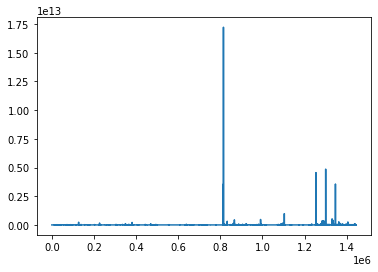

CPU times: user 5h 7min 18s, sys: 58.8 s, total: 5h 8min 17s
Wall time: 5h 8min 51s


In [6]:
%%time

train_flag='train'

def get_data():
    df=pd.read_csv('/content/drive/MyDrive/stock project/data/stock_data.csv')
    df.drop(['Date'],inplace=True,axis=1)
    return df

def scaling(env):
    list_of_states= []
    done = False
    while not done:
        action = np.random.choice(env.action_space)
        state, reward, done, info =env.step(action)

        list_of_states.append(state)

    scaler=StandardScaler()
    scaler.fit(list_of_states)
    return scaler

def make_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
episode_rewards=[]
test_action =[]

def play_one_episode(agent, env, is_train, is_test):
    
    temp_test_action = []
    temp_reward_array=[]
  
    
    state = env.reset() # get the initial state 
    state = scaler.transform([state]) # scale the state vector
    done = False

    while not done:
        action = agent.act(state) # get the next action
        
        if is_test==True:
            temp_test_action.append(action)
            
        next_state, reward, done, info = env.step(action) # perform the action
        temp_reward_array.append(reward)
        next_state = scaler.transform([next_state]) # scale the next state
        
        if is_train == 'train': # if the mode is training
            agent.train(state, action, reward, next_state, done) # Q-Learning with states' aggregation
        state = next_state # got to next state

    episode_rewards.append(temp_reward_array)
    if is_test==True:
        test_action.append(temp_test_action)
        
    return info['current value']



models_folder = '/content/drive/MyDrive/stock project/data/linear_rl_model_including_covid_19-final' # to store the Q-model prarameters
rewards_folder = '/content/drive/MyDrive/stock project/data/linear_rl_reward_including_covid_19-final' # to store the values of episodes


num_episodes= 1000 #1200 # epochs
#batch_size = 32
initial_investment = 200000

make_directory(models_folder)
make_directory(rewards_folder)

data=get_data()

n_timesteps,n_features=data.shape

n_train=n_timesteps*3//4

train_data=data.iloc[:n_train,:]
test_data=data.iloc[n_train:,:]

print(len(data))
print(len(train_data))
print(len(test_data))
          
          
env=Environment(train_data,initial_investment,3)
state_size=env.state_dim
action_size=len(env.action_space)
agent=Agent(state_size,action_size)

scaler=scaling(env)

portfolio_value=[]



    
for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, 'train', False)
    dt = datetime.now() - t0

    print(f"episode: {e +1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val)
    
    


agent.save(f'{models_folder}/linear.npz')

with open(f'{models_folder}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler,f)

plt.plot(agent.model.losses)
plt.show()

# save portfolio value for each episode
np.save(f'{rewards_folder}/{train_flag}.npy', portfolio_value)
np.save(f'{rewards_folder}/losses.npy', agent.model.losses)

# REWARDS

1000
1445
764.7253594936449


Text(0, 0.5, 'Reward')

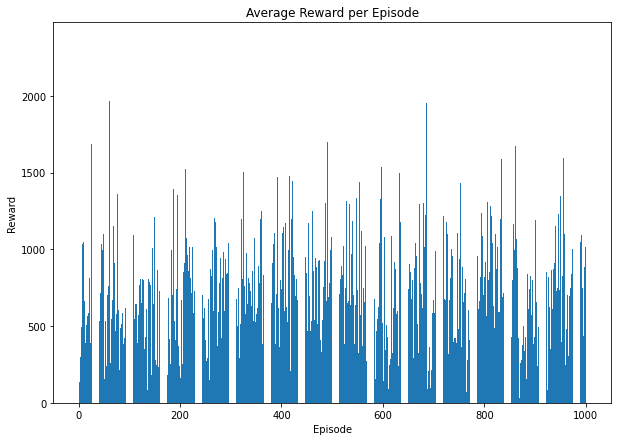

In [7]:
print(len(episode_rewards))
print(len(episode_rewards[0]))

episode_number=[]
average_rewards_all_episodes = []

for i in range(len(episode_rewards)):
    average_rewards_all_episodes.append(sum(episode_rewards[i])/len(episode_rewards[0]))
    episode_number.append(i+1)
    

    
#print(average_rewards_all_episodes)
print(sum(average_rewards_all_episodes)/num_episodes)
plt.figure(figsize=(10,7))
plt.bar(episode_number, list(average_rewards_all_episodes))
plt.title("Average Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

# LOSS

62641609.57997646


Text(0, 0.5, 'Loss')

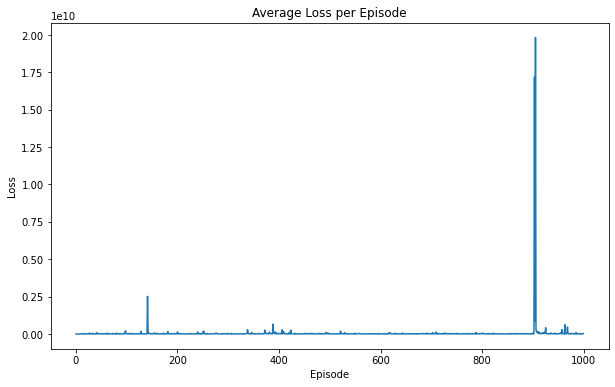

In [8]:
episode_loss = 0
average_loss_per_episode = []
k=0

for j in range(num_episodes):
    for i in range(k,k+900):
        episode_loss += agent.model.losses[i]
    k+=900
    average_loss_per_episode.append(episode_loss/900)
    episode_loss = 0

average_loss_all_episode = sum(average_loss_per_episode)/num_episodes
print(average_loss_all_episode)


plt.figure(figsize=(10,6))
plt.plot(average_loss_per_episode)
plt.title("Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("Loss")

In [9]:
train_reward = np.load("/content/drive/MyDrive/stock project/data/linear_rl_reward_including_covid_19-final/train.npy")
print(len(train_reward))
print("Maximum:            ", max(train_reward))
print("Minimum:            ", min(train_reward))
print("Mean:               ", np.mean(train_reward))
print("Standard Deviation: " ,np.std(train_reward))

1000
Maximum:             3611735.8399990867
Minimum:             225264.10000001942
Mean:                1305028.144468316
Standard Deviation:  511702.178677034


# TEST

In [15]:
%%time

num_episodes=200
train_flag='test'
test_portfolio_value=[]
test_data.reset_index(inplace=True,drop=True)


#load previous scaler
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# remake the env with the test data
test_env = Environment(test_data, initial_investment,3)


agent.epsilon = 0.01
agent.load(f'{models_folder}/linear.npz') 

episode_rewards=[]
    
for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, test_env, train_flag, True)
    dt = datetime.now() - t0

    print(f"episode: {e +1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    test_portfolio_value.append(val)
    
np.save(f'{rewards_folder}/{train_flag}.npy', test_portfolio_value)

episode: 1/200, episode end value: 677596.07, duration: 0:00:02.268314
episode: 2/200, episode end value: 600030.52, duration: 0:00:01.989518
episode: 3/200, episode end value: 612987.84, duration: 0:00:01.995148
episode: 4/200, episode end value: 612967.82, duration: 0:00:01.975224
episode: 5/200, episode end value: 610167.46, duration: 0:00:02.047336
episode: 6/200, episode end value: 651684.21, duration: 0:00:02.112541
episode: 7/200, episode end value: 612874.52, duration: 0:00:01.940015
episode: 8/200, episode end value: 612981.02, duration: 0:00:01.947424
episode: 9/200, episode end value: 611080.23, duration: 0:00:01.986336
episode: 10/200, episode end value: 617339.57, duration: 0:00:02.354014
episode: 11/200, episode end value: 571606.23, duration: 0:00:02.075799
episode: 12/200, episode end value: 637626.28, duration: 0:00:02.175234
episode: 13/200, episode end value: 518570.20, duration: 0:00:02.369703
episode: 14/200, episode end value: 616534.18, duration: 0:00:01.971101
e

200
845.6657677397598


Text(0, 0.5, 'Reward')

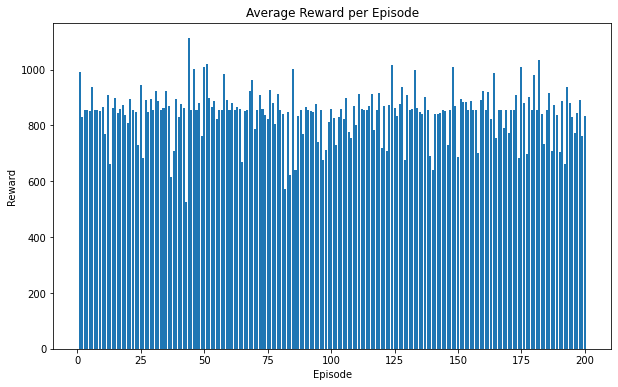

In [19]:
episode_number=[]
average_rewards_all_episodes = []

for i in range(len(episode_rewards)):
    average_rewards_all_episodes.append(sum(episode_rewards[i])/len(episode_rewards[0]))
    episode_number.append(i+1)
    

print(len(episode_rewards)) 
#print(average_rewards_all_episodes)
print(sum(average_rewards_all_episodes)/200)
plt.figure(figsize=(10,6))
plt.bar(episode_number, list(average_rewards_all_episodes) )
plt.title("Average Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

In [20]:
test_reward = np.load("/content/drive/MyDrive/stock project/data/linear_rl_reward_including_covid_19-final/test.npy")
print(len(test_reward))
mean = np.mean(test_reward)
print("Maximum:            ", max(test_reward))
print("Minimum:            ", min(test_reward))
print("Mean:               ", np.mean(test_reward))
print("Standard Deviation: " ,np.std(test_reward))

200
Maximum:             736236.3200007222
Minimum:             453603.8700000887
Mean:                607610.9000505644
Standard Deviation:  41749.984078450434


In [21]:
roi = ((mean-initial_investment)/initial_investment)*100
print(roi)

203.8054500252822


# GRAPHS

In [4]:
best_test_score_index = average_rewards_all_episodes.index(max(average_rewards_all_episodes))
test_action_list = []

for i in range(len(test_action[0])):
    test_action_list.append(env.action_list[test_action[best_test_score_index][i]])

BXPH = [i[0] for i in test_action_list]
LBFL = [i[1] for i in test_action_list]
RNTL = [i[2] for i in test_action_list]

data = pd.read_csv('/content/drive/MyDrive/stock project/data/stock_data.csv')
n_train=n_timesteps*3//4
test_data=data.iloc[n_train+1:,[0,1,7,13]]
test_data.reset_index(drop =True, inplace=True)

print(len(test_data))
print(len(BXPH))


test_data["BXPH"] = BXPH
test_data["LBFL"] = LBFL
test_data["RNTL"] = RNTL

NameError: ignored

In [23]:
test_data.to_csv("Including_Covid_19.csv")

In [24]:
test_data = pd.read_csv("Including_Covid_19.csv")
test_data.drop(["Unnamed: 0"], axis=1, inplace= True)
test_data.head()

,Date,Price_BXPH,Price_LBFL,Price_RNTL,BXPH,LBFL,RNTL
0,2020-10-21,104.64,22.0,954.22,2,0,0
1,2020-10-22,105.18,22.4,943.72,2,0,0
2,2020-10-25,106.36,23.0,941.32,2,0,0
3,2020-10-27,107.64,23.1,969.59,2,0,0
4,2020-10-28,106.64,22.5,969.50,2,0,0


In [25]:
def buy_sell(List):
    length_of_list = len(List)
    first_index_of_zero, first_index_of_two = List.index(0), List.index(2)

    if first_index_of_zero < first_index_of_two:
        current_value, current_index = 0, first_index_of_zero
    else:
        current_value, current_index = 2, first_index_of_two

    if current_index>0:
        List[0:current_index]=[3]*(current_index)

    while True :
        try:
            next_value = 2 - current_value
            next_index = List.index(next_value, current_index)
            List[current_index+1:next_index] = [3]*(next_index-current_index-1)
            current_value, current_index = next_value, next_index
        except ValueError:
            List[current_index+1:length_of_list]=[3]*(length_of_list-current_index-1)
            break
            
bxph = list(test_data["BXPH"])
buy_sell(bxph)
test_data["BXPH"] = bxph

lbfl = list(test_data["LBFL"])
buy_sell(lbfl)
test_data["LBFL"] = lbfl

rntl = list(test_data["RNTL"])
buy_sell(rntl)
test_data["RNTL"] = rntl

In [26]:
print(test_data["BXPH"].value_counts())
print(test_data["LBFL"].value_counts())
print(test_data["RNTL"].value_counts())

3    458
2     12
0     12
Name: BXPH, dtype: int64
3    459
0     12
2     11
Name: LBFL, dtype: int64
3    449
0     17
2     16
Name: RNTL, dtype: int64


In [27]:
test_data["BXPH_sell"]=0
test_data["BXPH_buy"]=0

test_data["LBFL_sell"]=0
test_data["LBFL_buy"]=0

test_data["RNTL_sell"]=0
test_data["RNTL_buy"]=0


for i in range(len(test_data)):
    #BXPH
    if test_data["BXPH"][i]==0:
        test_data["BXPH_sell"][i] = test_data["Price_BXPH"][i]  
    if test_data["BXPH"][i]==2:
        test_data["BXPH_buy"][i] = test_data["Price_BXPH"][i]
       
    #LBFL
    if test_data["LBFL"][i]==0:
        test_data["LBFL_sell"][i] = test_data["Price_LBFL"][i]
    if test_data["LBFL"][i]==2:
        test_data["LBFL_buy"][i] = test_data["Price_LBFL"][i]

    #RNTL
    if test_data["RNTL"][i]==0:
        test_data["RNTL_sell"][i] = test_data["Price_RNTL"][i]    
    if test_data["RNTL"][i]==2:
        test_data["RNTL_buy"][i] = test_data["Price_RNTL"][i]

Text(0, 0.5, 'Price')

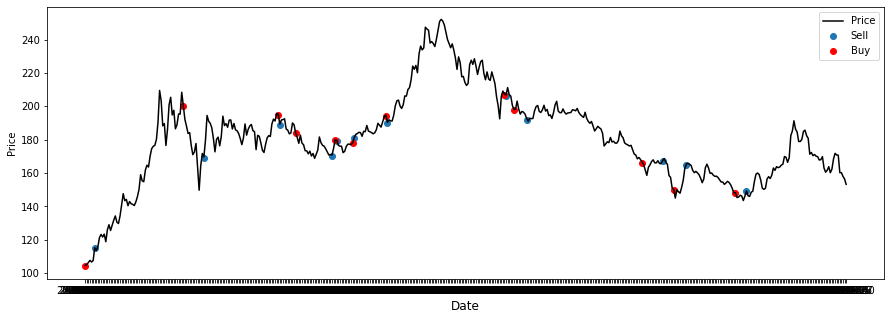

In [28]:
#Beximco Pharma
plt.figure(figsize=(15,5))
plt.plot(test_data["Date"], test_data["Price_BXPH"],"black")

x=np.array(test_data["Date"])

y=np.array(test_data["BXPH_sell"])
plt.scatter(x=x[y>1], y=y[y>1])


y=np.array(test_data["BXPH_buy"])
plt.scatter(x=x[y>0], y=y[y>0], c="red")

plt.legend(["Price", "Sell" , "Buy"])

plt.xlabel("Date",fontsize=12)
plt.ylabel("Price")

Text(0, 0.5, 'Price')

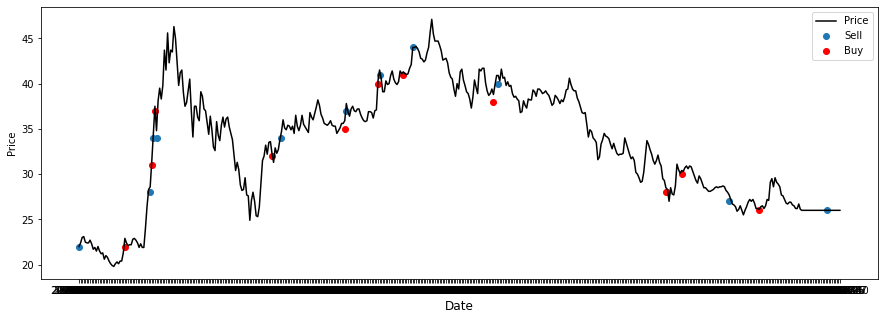

In [29]:
#Lanka Bangla
plt.figure(figsize=(15,5))
plt.plot(test_data["Date"], test_data["Price_LBFL"],"black")

x=np.array(test_data["Date"])

y=np.array(test_data["LBFL_sell"])
plt.scatter(x=x[y>1], y=y[y>1])


y=np.array(test_data["LBFL_buy"])
plt.scatter(x=x[y>0], y=y[y>0], c="red")

plt.legend(["Price", "Sell" , "Buy"])

plt.xlabel("Date",fontsize=12)
plt.ylabel("Price")

In [1]:
#Renata ltd
plt.figure(figsize=(15,5),dpi=1200)
plt.plot(test_data["Date"], test_data["Price_RNTL"],"black")

x=np.array(test_data["Date"])

y=np.array(test_data["RNTL_sell"])
plt.scatter(x=x[y>1], y=y[y>1])


y=np.array(test_data["RNTL_buy"])
plt.scatter(x=x[y>0], y=y[y>0], c="red")

plt.legend(["Price", "Sell" , "Buy"])

plt.xlabel("Date",fontsize=12)
plt.ylabel("Price")

NameError: ignored